# Word embeddings
Inspired by http://creatingdata.us/etc/streets/ we try to compute word vectors for each streetname and then visualize the relationship between streetnames.

In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import multiprocessing
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

## Creating the Word2Vec models
### Streets grouped by postcode

Reading the csv file of all streets into memory, this can be generated by the filter script. This assumes you have the file saved in the following folder

In [2]:
streets = pd.read_csv('../data/streets.csv')
# Group streets by postcode
groups = streets.groupby('postcode')

/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,5,6,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To train the Word2Vec model we normally need a list of sentences, usually mined from some text source. One way to emulate this with streetnames we consider each postcode a different sentence and list all the streetnames for a particular postcode.

In [3]:
# Create a list of lists containing the streetnames of each city
cleaned = []
for m_id, values in groups:
    city = []
    for nl, fr in values[['streetname_nl', 'streetname_fr']].values:
        # try to add nl and fr names, handling the cases where they are null
        try:
            city.append(nl.lower())
        except:
            pass
        try:
            city.append(fr.lower())
        except:
            pass
    cleaned.append(city)

Now we can calculate the word vectors for each streetname. First we create our model. Notable parameters are the `min_count` stating that only when a street occurs at least twice it can be included in the word vectors and the `window` which specifies how far words can be from eachother to still be associated with eachother (10 is the maximum value).  

In [4]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
postcode_grouped = Word2Vec(min_count=2,
                     window=10,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
# Build vocabulary, dropping streets that only occur once
postcode_grouped.build_vocab(cleaned, progress_per=10000)
# Train the word vectors
postcode_grouped.train(cleaned, total_examples=postcode_grouped.corpus_count, epochs=30, report_delay=1)
# Optimize model
postcode_grouped.init_sims(replace=True)

This model is able to extract some of the associations between the occurrences of streets in different cities. Especially when looking at commonly occuring streetnames we can see some other streets in the same style.

In [5]:
postcode_grouped.wv.most_similar(positive=["dorpsstraat"])

[('waterstraat', 0.9999365210533142),
 ('kortestraat', 0.9999345541000366),
 ('lindestraat', 0.9999336004257202),
 ('heidestraat', 0.9999011158943176),
 ('eikenlaan', 0.9998989105224609),
 ('markt', 0.9998941421508789),
 ('vaartstraat', 0.9998708963394165),
 ('rozenstraat', 0.999870777130127),
 ('pastorijstraat', 0.9998698830604553),
 ('kasteeldreef', 0.999805212020874)]

### Streets grouped on geolocation
We can group streets using geolocation as well (the geolocation of the addresses belonging to that street). We collect the streets in bins and make sure there is overlap between bins so neighboorhoods should be contained in at least one bin. Each bin is then interpreted as a 'sentence' for the creation of the word vectors.

Read the addresses csv file, this assumes you have the file saved in the following folder

In [6]:
addresses = pd.read_csv('../data/belgium_addresses.csv')

/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,8,9,10,12,13,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
min_x = addresses['EPSG:31370_x'].min()
max_x = addresses['EPSG:31370_x'].max()
min_y = addresses['EPSG:31370_y'].min()
max_y = addresses['EPSG:31370_y'].max()

In [8]:
binsize = 1000
coll = {}
# Get the ids of the necessary columns
x_id = addresses.columns.get_loc('EPSG:31370_x')
y_id = addresses.columns.get_loc('EPSG:31370_y')
nl_id = addresses.columns.get_loc('streetname_nl')
fr_id = addresses.columns.get_loc('streetname_fr')

for row in addresses.values:
    # Get the bin offsets
    x = (row[0] // binsize) * binsize
    y = (row[1] // binsize) * binsize
    bins = [
        (x, y),
        (x + binsize/2, y),
        (x, y + binsize/2),
        (x + binsize/2, y + binsize/2),
    ]
    for pos in bins:
        if pos not in coll:
            coll[pos] = set()
        try:
            coll[pos].add(row[nl_id].lower())
        except:
            pass
        try:
            coll[pos].add(row[fr_id].lower())
        except:
            pass
        
blocks = [list(el) for el in coll.values() if el]

In [9]:
geo_grouped = Word2Vec(min_count=10,
                     window=10,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

# Build vocabulary
geo_grouped.build_vocab(blocks, progress_per=10000)
# Train the word vectors
geo_grouped.train(blocks, total_examples=geo_grouped.corpus_count, epochs=30, report_delay=1)
# Optimize the model
geo_grouped.init_sims(replace=True)

In [10]:
geo_grouped.most_similar(positive=["dorpsstraat"])

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('kruisstraat', 0.6116258502006531),
 ('kewithdreef', 0.5953519940376282),
 ('kerkhofstraat', 0.5736434459686279),
 ('stationsstraat', 0.5568470358848572),
 ('kortestraat', 0.5566809177398682),
 ('oude kerkstraat', 0.550558865070343),
 ('zandstraat', 0.5504564642906189),
 ('kloosterstraat', 0.5420650243759155),
 ('patershof', 0.54120272397995),
 ('dorpsplein', 0.5305353403091431)]

## Visualizing the word vectors
The models generate word vectors with 300 dimensions, this kind of data is not easily visualized. To solve this we can apply dimensionality reduction, using the [UMAP](https://umap-learn.readthedocs.io/en/latest/) algorithm, to reduce the amount of dimensions to two which can then be visualized in a scatterplot

In [11]:
reducer = UMAP()

### Postcode groups

In [12]:
# Extract the vectors from the model
vectors = []
for word in postcode_grouped.wv.vocab:
    vectors.append(postcode_grouped.wv[word])

vectors = np.array(vectors)

# Create the low dimensional embedding
embedding = reducer.fit_transform(vectors)

/home/theod/.local/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/theod/.local/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.local/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7efd19ee5378>

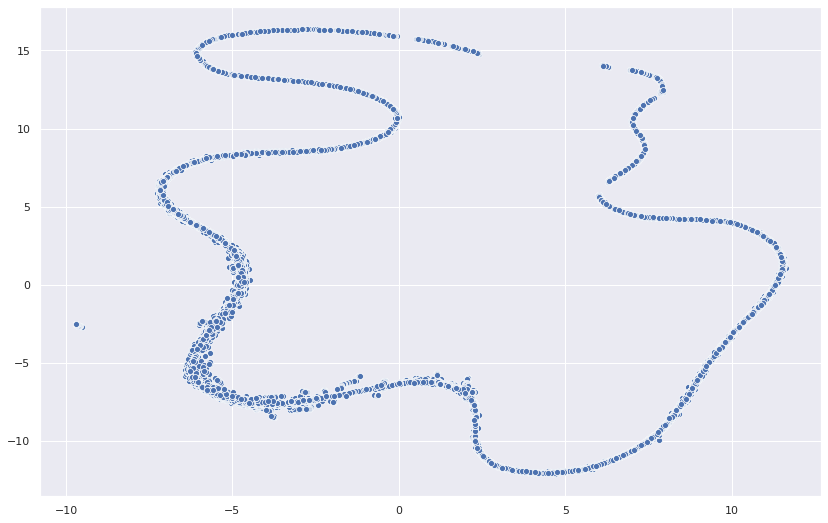

In [13]:
plt.figure(figsize=(14, 9))
sns.scatterplot(embedding[:, 0], embedding[:, 1])

### Geo groups

In [14]:
# Extract the vectors from the model
vectors = []
for word in geo_grouped.wv.vocab:
    vectors.append(geo_grouped.wv[word])

vectors = np.array(vectors)

# Create the low dimensional embedding
embedding = reducer.fit_transform(vectors)

/home/theod/.local/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


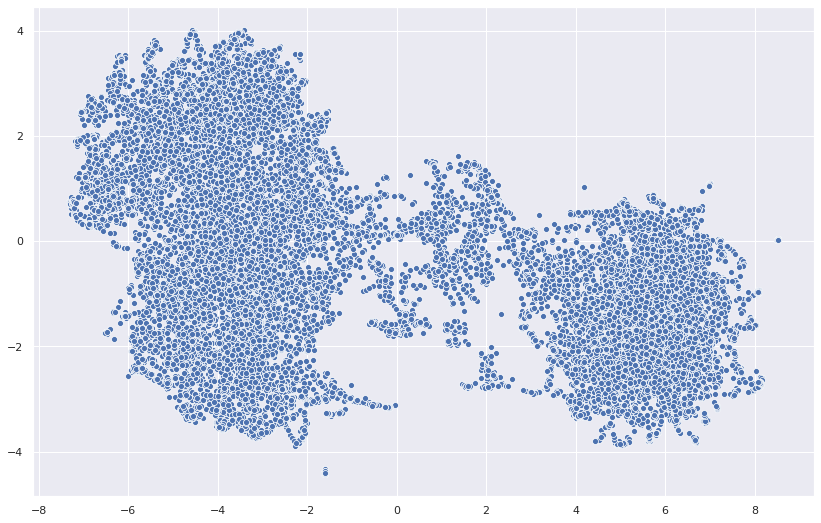

In [15]:
plt.figure(figsize=(14, 9))
sns.scatterplot(embedding[:, 0], embedding[:, 1])